In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


file_path = '/content/drive/MyDrive/gnn_fraud_project /PS_20174392719_1491204439457_log.csv'



In [ ]:
# STEP 1 — Colab Setup

In [ ]:

!pip install pandas numpy matplotlib seaborn tqdm scikit-learn

In [ ]:
# STEP 2 — Load Dataset

In [ ]:
import pandas as pd
import numpy as np


file_path = '/content/drive/MyDrive/gnn_fraud_project /PS_20174392719_1491204439457_log.csv'

df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()

Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# STEP 3 — Basic Audit (Very Important)

In [ ]:
# Check fraud ratio
fraud_ratio = df['isFraud'].mean()
print("Fraud Ratio:", fraud_ratio)

# Unique accounts
print("Unique Origin Accounts:", df['nameOrig'].nunique())
print("Unique Destination Accounts:", df['nameDest'].nunique())

# Time range
print("Min step:", df['step'].min())
print("Max step:", df['step'].max())

Fraud Ratio: 0.001290820448180152
Unique Origin Accounts: 6353307
Unique Destination Accounts: 2722362
Min step: 1
Max step: 743


In [ ]:
# STEP 4 — Memory Optimization (CRITICAL)

In [ ]:
# Convert types
df['type'] = df['type'].astype('category')

for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest']:
    df[col] = df[col].astype('float32')

for col in ['step', 'isFraud', 'isFlaggedFraud']:
    df[col] = df[col].astype('int32')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int32   
 1   type            category
 2   amount          float32 
 3   nameOrig        object  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        object  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         int32   
 10  isFlaggedFraud  int32   
dtypes: category(1), float32(5), int32(3), object(2)
memory usage: 297.3+ MB
None


In [ ]:
# STEP 5 — Temporal Split

In [ ]:
train_df = df[df['step'] <= 500].copy()
val_df = df[(df['step'] > 500) & (df['step'] <= 600)]
test_df = df[df['step'] > 600]

print(train_df.shape, val_df.shape, test_df.shape)

(6061807, 11) (197240, 11) (103573, 11)


In [ ]:
# STEP 6 — Basic Feature Engineering (Transaction-Level)

In [ ]:
# Transaction velocity per origin account
train_df['tx_count'] = train_df.groupby('nameOrig')['nameOrig'].transform('count')

# Avg amount per origin
train_df['avg_amt_orig'] = train_df.groupby('nameOrig')['amount'].transform('mean')

# Encode transaction type
train_df = pd.get_dummies(train_df, columns=['type'], drop_first=True)

train_df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,tx_count,avg_amt_orig,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0,1,9839.639648,False,False,True,False
1,1,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0,1,1864.280029,False,False,True,False
2,1,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0,1,181.000000,False,False,False,True
3,1,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0,1,181.000000,True,False,False,False
4,1,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0,1,11668.139648,False,False,True,False


In [ ]:
# STEP 7 — Fraud Distribution Visualization

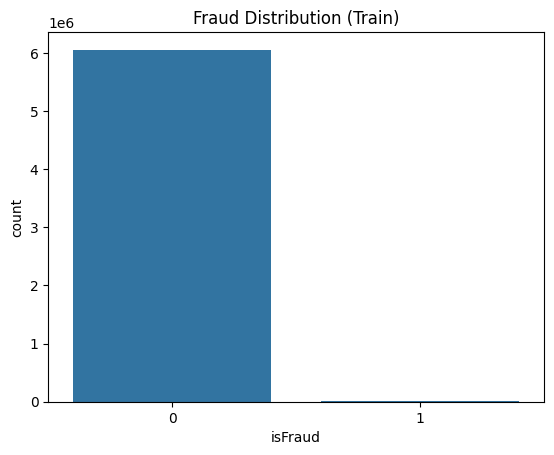

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='isFraud', data=train_df)
plt.title("Fraud Distribution (Train)")
plt.show()

In [ ]:
# WEEK 2 — TABULAR BASELINE (NO GNN YET)

In [ ]:
# STEP 0 — Data Leakage Fix (Very Important)

In [ ]:
train_df = df[df['step'] <= 500].copy()
val_df = df[(df['step'] > 500) & (df['step'] <= 600)].copy()
test_df = df[df['step'] > 600].copy()

In [ ]:
# STEP 1 — Feature Engineering (Safe Version)

In [ ]:
# Historical stats from TRAIN ONLY
orig_tx_count = train_df.groupby('nameOrig').size().rename("orig_tx_count")
orig_avg_amt = train_df.groupby('nameOrig')['amount'].mean().rename("orig_avg_amt")

# Merge into train
train_df = train_df.merge(orig_tx_count, on='nameOrig', how='left')
train_df = train_df.merge(orig_avg_amt, on='nameOrig', how='left')

In [ ]:
# Val/Test me leakage-free merge
val_df = val_df.merge(orig_tx_count, on='nameOrig', how='left')
val_df = val_df.merge(orig_avg_amt, on='nameOrig', how='left')

test_df = test_df.merge(orig_tx_count, on='nameOrig', how='left')
test_df = test_df.merge(orig_avg_amt, on='nameOrig', how='left')

NameError: name 'val_df' is not defined

In [ ]:
# Missing values handle karo (cold start accounts)
for df_ in [train_df, val_df, test_df]:
    df_['orig_tx_count'] = df_['orig_tx_count'].fillna(0)
    df_['orig_avg_amt'] = df_['orig_avg_amt'].fillna(0)

In [ ]:
# STEP 2 — Encode Transaction Type

In [ ]:
train_df = pd.get_dummies(train_df, columns=['type'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['type'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['type'], drop_first=True)

In [ ]:
val_df = val_df.reindex(columns=train_df.columns, fill_value=0)
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

In [ ]:
# STEP 3 — Feature Selection

In [ ]:
drop_cols = ['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']

X_train = train_df.drop(columns=drop_cols)
y_train = train_df['isFraud']

X_val = val_df.drop(columns=drop_cols)
y_val = val_df['isFraud']

X_test = test_df.drop(columns=drop_cols)
y_test = test_df['isFraud']

In [ ]:
# STEP 4 — Logistic Regression Baseline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

model = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

val_probs = model.predict_proba(X_val)[:, 1]

pr_auc = average_precision_score(y_val, val_probs)
print("Validation PR-AUC:", pr_auc)

Validation PR-AUC: 0.7386225254621741


In [ ]:
# STEP 5 — Precision-Recall Curve

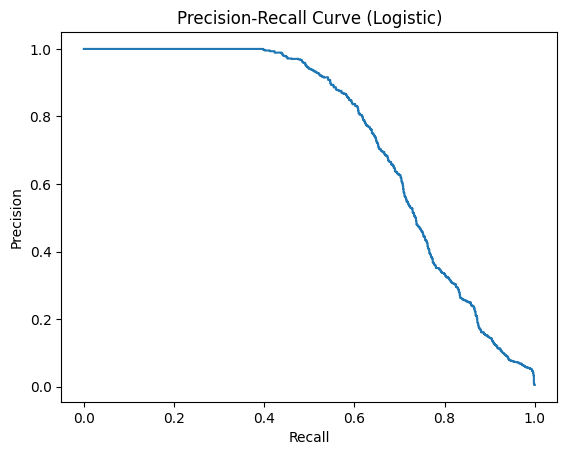

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_val, val_probs)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic)")
plt.show()

In [ ]:
# WEEK 2.5 — DIAGNOSTIC EXPERIMENT (Critical)

In [ ]:
# STEP 1 — Balance Columns Remove

In [ ]:
balance_cols = [
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest'
]

X_train_diag = X_train.drop(columns=balance_cols)
X_val_diag = X_val.drop(columns=balance_cols)
X_test_diag = X_test.drop(columns=balance_cols)

In [ ]:
# STEP 2 — Logistic Dobara Train

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

diag_model = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
diag_model.fit(X_train_diag, y_train)

val_probs_diag = diag_model.predict_proba(X_val_diag)[:, 1]

pr_auc_diag = average_precision_score(y_val, val_probs_diag)
print("Validation PR-AUC (No Balance Features):", pr_auc_diag)

Validation PR-AUC (No Balance Features): 0.07248820815534474


In [ ]:
# (Week 2 Final Step)

In [ ]:
# Step 1 — Clean Feature Set Define

In [ ]:
clean_drop_cols = [
    'nameOrig',
    'nameDest',
    'isFraud',
    'isFlaggedFraud',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest'
]

X_train_clean = train_df.drop(columns=clean_drop_cols)
y_train = train_df['isFraud']

X_val_clean = val_df.drop(columns=clean_drop_cols)
y_val = val_df['isFraud']

X_test_clean = test_df.drop(columns=clean_drop_cols)
y_test = test_df['isFraud']

In [ ]:
# Step 2 — XGBoost Train

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum(),
    tree_method='hist',
    n_jobs=-1
)

xgb_model.fit(X_train_clean, y_train)

val_probs_xgb = xgb_model.predict_proba(X_val_clean)[:, 1]

pr_auc_xgb = average_precision_score(y_val, val_probs_xgb)

print("Validation PR-AUC (XGBoost Clean):", pr_auc_xgb)

Validation PR-AUC (XGBoost Clean): 0.043466269007156166


In [ ]:
# WEEK 3 — ADVANCED BEHAVIORAL FEATURES

In [ ]:
# Step 1 — Time Since Last Transaction (Per nameOrig)

In [ ]:
# Make sure sorted
train_df = train_df.sort_values(['nameOrig', 'step'])
val_df = val_df.sort_values(['nameOrig', 'step'])
test_df = test_df.sort_values(['nameOrig', 'step'])

In [ ]:
# Time since last transaction
train_df['prev_step'] = train_df.groupby('nameOrig')['step'].shift(1)
train_df['time_delta'] = train_df['step'] - train_df['prev_step']

# First transaction ke liye fill
train_df['time_delta'] = train_df['time_delta'].fillna(-1)

In [ ]:
# Val/Test me leakage-safe logic

In [ ]:
last_train_step = train_df.groupby('nameOrig')['step'].max().rename("last_train_step")

In [ ]:
# Merge into val:

In [ ]:
val_df = val_df.merge(last_train_step, on='nameOrig', how='left')

val_df['time_delta'] = val_df['step'] - val_df['last_train_step']
val_df['time_delta'] = val_df['time_delta'].fillna(-1)

In [ ]:
# Same for test:

In [ ]:
test_df = test_df.merge(last_train_step, on='nameOrig', how='left')

test_df['time_delta'] = test_df['step'] - test_df['last_train_step']
test_df['time_delta'] = test_df['time_delta'].fillna(-1)

In [ ]:
print(train_df[['time_delta','isFraud']].describe())

         time_delta       isFraud
count  6.061807e+06  6.061807e+06
mean  -8.056085e-01  9.173832e-04
std    6.419069e+00  3.027444e-02
min   -1.000000e+00  0.000000e+00
25%   -1.000000e+00  0.000000e+00
50%   -1.000000e+00  0.000000e+00
75%   -1.000000e+00  0.000000e+00
max    4.870000e+02  1.000000e+00


In [ ]:
train_df.groupby('isFraud')['time_delta'].mean()

,time_delta
isFraud,
0,-0.805829
1,-0.565006


In [ ]:
# STEP 2 — Destination Transaction Count (Train Only)

In [ ]:
# Destination transaction count (train only)
dest_tx_count = train_df.groupby('nameDest').size().rename("dest_tx_count")

train_df = train_df.merge(dest_tx_count, on='nameDest', how='left')
val_df = val_df.merge(dest_tx_count, on='nameDest', how='left')
test_df = test_df.merge(dest_tx_count, on='nameDest', how='left')

# Cold start handling
for df_ in [train_df, val_df, test_df]:
    df_['dest_tx_count'] = df_['dest_tx_count'].fillna(0)

In [ ]:
# STEP 3 — Destination Fraud Rate (Train Only)

In [ ]:
dest_fraud_rate = train_df.groupby('nameDest')['isFraud'].mean().rename("dest_fraud_rate")

train_df = train_df.merge(dest_fraud_rate, on='nameDest', how='left')
val_df = val_df.merge(dest_fraud_rate, on='nameDest', how='left')
test_df = test_df.merge(dest_fraud_rate, on='nameDest', how='left')

for df_ in [train_df, val_df, test_df]:
    df_['dest_fraud_rate'] = df_['dest_fraud_rate'].fillna(0)

In [ ]:
# STEP 4 — Destination Velocity (Time-Aware)

In [ ]:
# Train
train_df['dest_prev_step'] = train_df.groupby('nameDest')['step'].shift(1)
train_df['dest_time_delta'] = train_df['step'] - train_df['dest_prev_step']
train_df['dest_time_delta'] = train_df['dest_time_delta'].fillna(-1)

In [ ]:
last_train_dest_step = train_df.groupby('nameDest')['step'].max().rename("last_train_dest_step")

val_df = val_df.merge(last_train_dest_step, on='nameDest', how='left')
val_df['dest_time_delta'] = val_df['step'] - val_df['last_train_dest_step']
val_df['dest_time_delta'] = val_df['dest_time_delta'].fillna(-1)

test_df = test_df.merge(last_train_dest_step, on='nameDest', how='left')
test_df['dest_time_delta'] = test_df['step'] - test_df['last_train_dest_step']
test_df['dest_time_delta'] = test_df['dest_time_delta'].fillna(-1)

In [ ]:
# Quick Sanity Check

In [ ]:
train_df.groupby('isFraud')[['dest_tx_count','dest_fraud_rate','dest_time_delta']].mean()

,dest_tx_count,dest_fraud_rate,dest_time_delta
isFraud,,,
0,11.201333,0.000591,-0.392367
1,9.788347,0.356385,-33.631721


In [ ]:
# STEP 5 — Rebuild Clean Feature Matrix

In [ ]:
final_drop_cols = [
    'nameOrig',
    'nameDest',
    'isFraud',
    'isFlaggedFraud',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'prev_step',
    'dest_prev_step',
    'last_train_step',
    'last_train_dest_step'
]

In [ ]:
X_train_final = train_df.drop(columns=final_drop_cols, errors='ignore')
X_val_final = val_df.drop(columns=final_drop_cols, errors='ignore')

In [ ]:
X_val_final = X_val_final.reindex(columns=X_train_final.columns, fill_value=0)

In [ ]:
# STEP 6 — XGBoost Re-Run

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

xgb_model2 = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
    tree_method='hist',
    n_jobs=-1
)

xgb_model2.fit(X_train_final, y_train)

val_probs2 = xgb_model2.predict_proba(X_val_final)[:, 1]
pr_auc2 = average_precision_score(y_val, val_probs2)

print("Validation PR-AUC (With Destination Features):", pr_auc2)

Validation PR-AUC (With Destination Features): 0.010323163129808157


In [ ]:
# WEEK 4 — SYNTHETIC FRAUD RING INJECTION

In [ ]:
# STEP 1 — Fraud Subset Identify

In [ ]:
fraud_train = train_df[train_df['isFraud'] == 1].copy()
nonfraud_train = train_df[train_df['isFraud'] == 0].copy()

print("Original Fraud Count:", len(fraud_train))

Original Fraud Count: 5561


In [ ]:
# STEP 2 — Select Injection Seed Accounts

In [ ]:
import numpy as np

np.random.seed(42)

seed_frauds = fraud_train.sample(200).copy()

In [ ]:
# STEP 3 — Create Synthetic Mule Destinations

In [ ]:
num_mules = 20

mule_accounts = [f"SYN_MULE_{i}" for i in range(num_mules)]

In [ ]:
# STEP 4 — Inject Multi-Origin Fraud Ring

In [ ]:
synthetic_rows = []

for i, mule in enumerate(mule_accounts):
    origins_subset = seed_frauds.iloc[i*10:(i+1)*10]

    for _, row in origins_subset.iterrows():
        new_row = row.copy()
        new_row['nameDest'] = mule
        new_row['amount'] = row['amount'] * 1.1
        new_row['step'] = row['step'] + 1  # temporal burst

        synthetic_rows.append(new_row)

synthetic_df = pd.DataFrame(synthetic_rows)

In [ ]:
# STEP 5 — Append to Train

In [ ]:
train_df_aug = pd.concat([train_df, synthetic_df], ignore_index=True)

print("Train size before:", len(train_df))
print("Train size after injection:", len(train_df_aug))

Train size before: 6061807
Train size after injection: 6062007


In [ ]:
# STEP 6 — Recompute Destination Features

In [ ]:
train_df = train_df_aug.copy()

In [ ]:
# Destination transaction count
dest_tx_count = train_df.groupby('nameDest').size().rename("dest_tx_count")

train_df = train_df.merge(dest_tx_count, on='nameDest', how='left')
val_df = val_df.merge(dest_tx_count, on='nameDest', how='left')
test_df = test_df.merge(dest_tx_count, on='nameDest', how='left')

for df_ in [train_df, val_df, test_df]:
    df_['dest_tx_count'] = df_['dest_tx_count'].fillna(0)

In [ ]:
# Destination Fraud Rate Recompute

In [ ]:
dest_fraud_rate = train_df.groupby('nameDest')['isFraud'].mean().rename("dest_fraud_rate")

train_df = train_df.merge(dest_fraud_rate, on='nameDest', how='left')
val_df = val_df.merge(dest_fraud_rate, on='nameDest', how='left')
test_df = test_df.merge(dest_fraud_rate, on='nameDest', how='left')

for df_ in [train_df, val_df, test_df]:
    df_['dest_fraud_rate'] = df_['dest_fraud_rate'].fillna(0)

In [ ]:
# Important Observation

In [ ]:
train_df[train_df['nameDest'].str.contains("SYN_MULE")][
    ['dest_tx_count','dest_fraud_rate']
].head()

,dest_tx_count,dest_fraud_rate
6061807,10,1.0
6061808,10,1.0
6061809,10,1.0
6061810,10,1.0
6061811,10,1.0


In [ ]:
# Rebuild Baseline After Injection

In [ ]:
# Final Feature Builder

In [ ]:
def build_feature_matrix(df, feature_cols):
    """
    Returns feature matrix aligned to given feature_cols.
    """
    X = df[feature_cols].copy()
    return X

In [ ]:
# STEP 2 — Define Drop Columns (Helper + Leakage + Balance)

In [ ]:
final_drop_cols = [
    'nameOrig',
    'nameDest',
    'isFraud',
    'isFlaggedFraud',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'prev_step',
    'dest_prev_step',
    'last_train_step',
    'last_train_dest_step'
]

In [ ]:
# STEP 3 — Build Clean Train Matrix

In [ ]:
# Drop unwanted columns
train_model_df = train_df.drop(columns=final_drop_cols, errors='ignore')
val_model_df   = val_df.drop(columns=final_drop_cols, errors='ignore')

# Separate labels
y_train = train_df['isFraud'].values
y_val   = val_df['isFraud'].values

# Save feature list from train only
feature_cols = train_model_df.columns.tolist()

# Align validation to train
val_model_df = val_model_df.reindex(columns=feature_cols, fill_value=0)

# Convert to numpy (memory + speed)
X_train_final = train_model_df.values
X_val_final   = val_model_df.values

In [ ]:
# STEP 4 — Optimized XGBoost Config (Colab Friendly)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score
import numpy as np

scale_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

xgb_model2 = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_weight,
    tree_method='hist',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model2.fit(X_train_final, y_train)